In [9]:
import collections
from qiskit import *
import supermarq
import cirq
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Introduction

## Artifact Evaluation
This notebook was created to serve as the reproducibility artifact for the paper "SupermarQ: A Scalable Quantum Benchmark Suite" accepted in the 28th IEEE International Symposium on High-Performance Computer Architecture (HPCA-28). The main contribution of this paper includes a quantum benchmark suite comprised of a number of different quantum applications. The software provided within this artifact includes the circuit generators and score functions for each benchmark application. This notebook provides an example of each benchmark: generating the quantum circuits with the provided parameters, simulating their execution via noisy density matrix simulation provided through Cirq (more on this in the following section), and finally computing the performance score of those executions.

This notebook is meant to serve as an overview of the process used to generate and collect the benchmark results that were presented in the above paper. Each benchmark is defined within a file found in the `supermarq/benchmarks/` directory. This file defines a benchmark class that includes a function for generating the quantum circuits, and a function for evaluating the benchmark score.

The first section of this notebook, **Benchmarks**, provides an overview of the benchmarks within the SupermarQ suite. The second section, **Features**, contains examples showing how the feature plots in Figure 1 were created (the corresponding code for the feature plots is contained in `supermarq/features.py`). Finally, the last section **Correlations** uses the raw data stored as Pandas dataframes within the `data/` directory to recreate Figures 4 and 5.

### Simulation vs. Hardware Execution
The benchmark results included in the SupermarQ paper were evaluated on real quantum computers including both superconducting and trapped ion processors. These systems were accessed over the cloud via services provided by IBM Quantum and Braket (Amazon). Access to some of these systems is restricted to certain users and the cost of running quantum programs varies among them. Because of these reasons, it would be impractical to exactly reproduce the results within the SupermarQ paper. Instead, we substitute the hardware executions with circuit simulations conducted via the Cirq SDK. 

### Installation Guide
This artifact was generated using Python 3.8. We recommend creating a fresh python virtual environment. Then, the supermarq software package and all of its dependencies can be installed via:

```
cd SupermarQ_HPCA_Artifact
pip install -r requirements.txt
pip install -e .
```

In [2]:
def noisy_simulation(circuit: cirq.Circuit, p: float) -> collections.Counter:
    """
    Simulate the given circuit under a depolarizing noise model where every
    gate operation has the chance of depolarizing the qubit with probability p.
    """
    
    shots = 1000
    result = cirq.Simulator().run(circuit.with_noise(cirq.depolarize(p=p)),
                                  repetitions=shots)

    num_measured_qubits = []
    for _, op in circuit.findall_operations(cirq.is_measurement):
        num_measured_qubits.append(len(op.qubits))
    raw_counts = result.multi_measurement_histogram(keys=result.measurements.keys())

    # cirq.Result.multi_measurement_histogram returns a collection.Counter object
    # where the keys are tuples of integers and the values are the shot counts.
    # The integers in the keys indicate the bitstring result of each set of measurement tags.
    counts: Dict[str, float] = collections.defaultdict(float)
    for key, val in raw_counts.items():
        bit_list = []
        for int_tag, num_bits in zip(key, num_measured_qubits):
            bit_list.extend(cirq.value.big_endian_int_to_bits(int_tag, bit_count=num_bits))
        counts["".join([str(b) for b in bit_list])] = val / shots

    return collections.Counter(counts)

# Benchmarks

## GHZ

In [3]:
supermarq.ghz.GHZ?

In [4]:
# Create the benchmark object and circuit
num_qubits = 5
ghz = supermarq.ghz.GHZ(num_qubits)
ghz_circuit = ghz.circuit()
print(ghz_circuit)

0: ───H───@───────────────M───
          │               │
1: ───────X───@───────────M───
              │           │
2: ───────────X───@───────M───
                  │       │
3: ───────────────X───@───M───
                      │   │
4: ───────────────────X───M───


In [7]:
# Perform noisy simulation and evaluate the benchmark score function
ghz_scores = []
for error_prob in [0.0, 0.005, 0.02]:
    counts = noisy_simulation(ghz_circuit, p=error_prob)
    score = ghz.score(counts)
    ghz_scores.append((error_prob, score))
    print(f'With {error_prob*100:.1f}% error probability, GHZ score = {score:.4f}')

With 0.0% error probability, GHZ score = 0.9998
With 0.5% error probability, GHZ score = 0.9440
With 2.0% error probability, GHZ score = 0.7145


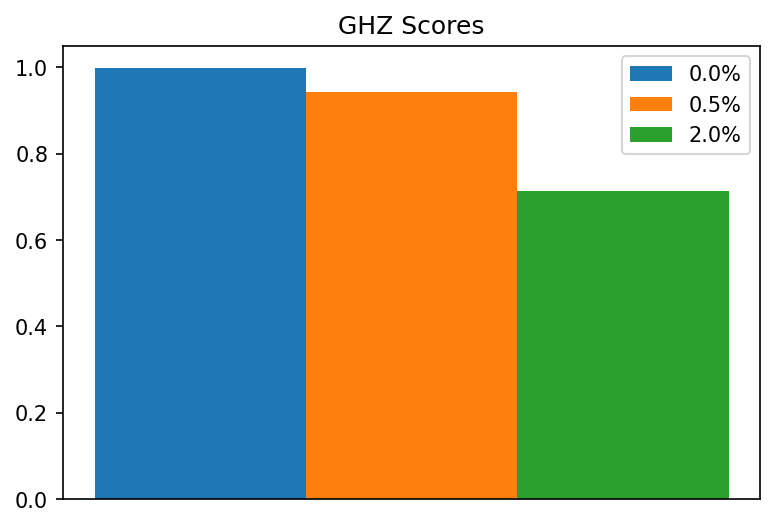

In [8]:
# Plot the results
fig, ax = plt.subplots(dpi=150)
width = 0.1

for i, (error_prob, score) in enumerate(ghz_scores):
    x = width * i
    ax.bar(x, score, width=width, label=f'{error_prob * 100:.1f}%', align='edge')

ax.legend()
ax.set_title('GHZ Scores')
ax.get_xaxis().set_visible(False)

## Mermin-Bell

In [7]:
supermarq.mermin_bell.MerminBell?

Init signature: supermarq.mermin_bell.MerminBell(num_qubits: int) -> None
Docstring:     
The Mermin-Bell benchmark is a test of a quantum computer's ability
to exploit purely quantum phenomemna such as superposition and entanglement.
It is based on the famous Bell-inequality tests of locality.

Performance is based on a QPU's ability to prepare a GHZ state and measure
the Mermin operator.
File:           ~/Workspace/SuperTech/SupermarQ_HPCA_Artifact/supermarq/benchmarks/mermin_bell.py
Type:           type
Subclasses:     


In [8]:
# Create the benchmark object and circuit
num_qubits = 3
merminbell = supermarq.mermin_bell.MerminBell(num_qubits)
mb_circuit = merminbell.circuit()
print(mb_circuit)

0: ───Rx(-0.5π)───@───────────@───────X───X───S───@───H───────M───
                  │           │       │   │       │           │
1: ───────────────X───@───H───┼───@───┼───@───────@───S───H───M───
                      │       │   │   │                       │
2: ───────────────────X───H───X───X───@───S───H───────────────M───


In [9]:
# Perform noisy simulation and evaluate the benchmark score function
merminbell_scores = []
for error_prob in [0.0, 0.005, 0.02]:
    counts = noisy_simulation(mb_circuit, p=error_prob)
    score = merminbell.score(counts)
    merminbell_scores.append((error_prob, score))
    print(f'With {error_prob*100:.1f}% error probability, MerminBell score = {score:.4f}')

With 0.0% error probability, MerminBell score = 1.0000
With 0.5% error probability, MerminBell score = 0.9315
With 2.0% error probability, MerminBell score = 0.7570


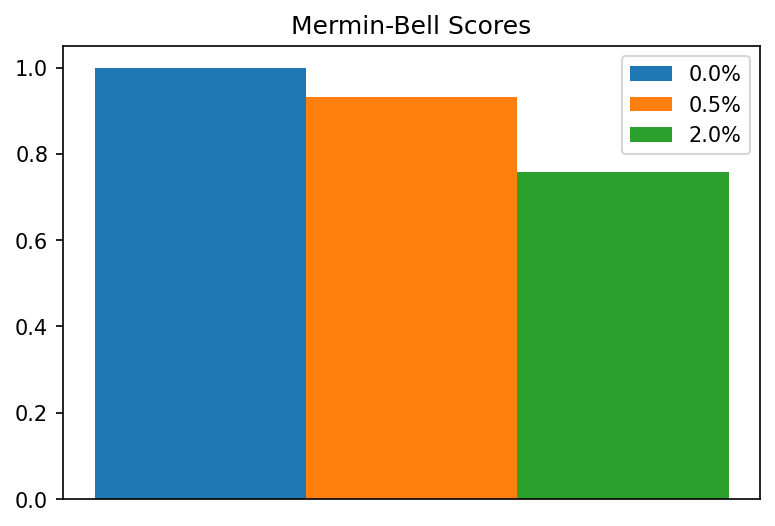

In [10]:
# Plot the results
fig, ax = plt.subplots(dpi=150)
width = 0.1

for i, (error_prob, score) in enumerate(merminbell_scores):
    
    x = width * i
    ax.bar(x, score, width=width, label=f'{error_prob * 100:.1f}%', align='edge')

ax.legend()
ax.set_title('Mermin-Bell Scores')
ax.get_xaxis().set_visible(False)

## Bit Code

In [11]:
supermarq.bit_code.BitCode?

Init signature:
supermarq.bit_code.BitCode(
    num_data_qubits: int,
    num_rounds: int,
    bit_state: List[int] = [0, 1, 0],
) -> None
Docstring:     
Creates a circuit for syndrome measurement in a bit-flip error correcting code.

Args:
- num_data: The number of data qubits
- num_rounds: The number of measurement rounds
- bit_state: A list denoting the state to initialize each data qubit to.

returns a cirq circuit for the bit-flip error correcting code
File:           ~/Workspace/SuperTech/SupermarQ_HPCA_Artifact/supermarq/benchmarks/bit_code.py
Type:           type
Subclasses:     


In [12]:
# Create the benchmark object and circuit
num_data_qubits = 3
num_rounds = 2
bit_state = [0, 1, 0]
bitcode = supermarq.bit_code.BitCode(num_data_qubits, num_rounds, bit_state)
bitcode_circuit = bitcode.circuit()
print(bitcode_circuit)

0: ───@─────────────────────────@─────────────────────────────────────────────────────M───
      │                         │                                                     │
1: ───X───X───M('mcm1_0')───R───X─────────────X───M('mcm1_1')───R─────────────────────M───
          │                                   │                                       │
2: ───X───@───@───────────────────────────────@───@───────────────────────────────────M───
              │                                   │                                   │
3: ───────────X─────────────X───M('mcm3_0')───R───X─────────────X───M('mcm3_1')───R───M───
                            │                                   │                     │
4: ─────────────────────────@───────────────────────────────────@─────────────────────M───


In [13]:
# Perform noisy simulation and evaluate the benchmark score function
bitcode_scores = []
for error_prob in [0.0, 0.005, 0.02]:
    counts = noisy_simulation(bitcode_circuit, p=error_prob)
    score = bitcode.score(counts)
    bitcode_scores.append((error_prob, score))
    print(f'With {error_prob*100:.1f}% error probability, BitCode score = {score:.4f}')

With 0.0% error probability, BitCode score = 1.0000
With 0.5% error probability, BitCode score = 0.8600
With 2.0% error probability, BitCode score = 0.5480


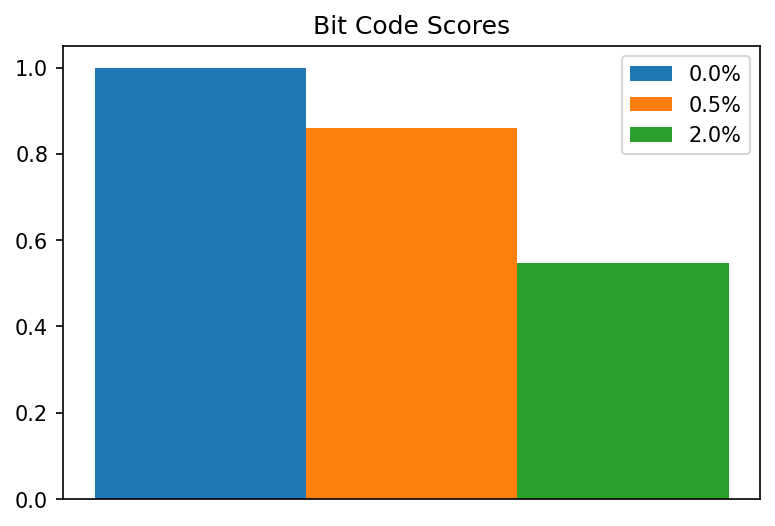

In [14]:
# Plot the results
fig, ax = plt.subplots(dpi=150)
width = 0.1

for i, (error_prob, score) in enumerate(bitcode_scores):
    
    x = width * i
    ax.bar(x, score, width=width, label=f'{error_prob * 100:.1f}%', align='edge')

ax.legend()
ax.set_title('Bit Code Scores')
ax.get_xaxis().set_visible(False)

## Phase Code

In [15]:
supermarq.phase_code.PhaseCode?

Init signature:
supermarq.phase_code.PhaseCode(
    num_data_qubits: int,
    num_rounds: int,
    phase_state: List[int] = [0, 1, 0],
) -> None
Docstring:     
Creates a circuit for syndrome measurement in a phase-flip error
correcting code.

Args:
- num_data: The number of data qubits
- num_rounds: The number of measurement rounds
- phase_state: A list denoting the state to initialize each data
               qubit to. Currently just + or - states. 0 -> +, 1 -> -

returns a cirq circuit for the phase-flip error correcting code
File:           ~/Workspace/SuperTech/SupermarQ_HPCA_Artifact/supermarq/benchmarks/phase_code.py
Type:           type
Subclasses:     


In [16]:
# Create the benchmark object and circuit
num_data_qubits = 3
num_rounds = 2
phase_state = [0, 1, 0]
phasecode = supermarq.phase_code.PhaseCode(num_data_qubits, num_rounds, phase_state)
phasecode_circuit = phasecode.circuit()
print(phasecode_circuit)

0: ───H───H───@───H───H───────────────────────────────────@───H───────────────────────────────────────────M───
              │                                           │                                               │
1: ───H───────@───@───H───M('mcm1_0')───R───H─────────────@───@───H───M('mcm1_1')───R─────────────────────M───
                  │                                           │                                           │
2: ───X───H───H───@───@───H─────────────H─────────────────────@───@───H───────────────────────────────────M───
                      │                                           │                                       │
3: ───H───────────────@───@─────────────H───M('mcm3_0')───R───H───@───@─────────────H───M('mcm3_1')───R───M───
                          │                                           │                                   │
4: ───H───H───────────────@─────────────H───H─────────────────────────@─────────────H─────────────────────M───


In [17]:
# Perform noisy simulation and evaluate the benchmark score function
phasecode_scores = []
for error_prob in [0.0, 0.005, 0.02]:
    counts = noisy_simulation(phasecode_circuit, p=error_prob)
    score = phasecode.score(counts)
    phasecode_scores.append((error_prob, score))
    print(f'With {error_prob*100:.1f}% error probability, PhaseCode score = {score:.4f}')

With 0.0% error probability, PhaseCode score = 0.9958
With 0.5% error probability, PhaseCode score = 0.8430
With 2.0% error probability, PhaseCode score = 0.4829


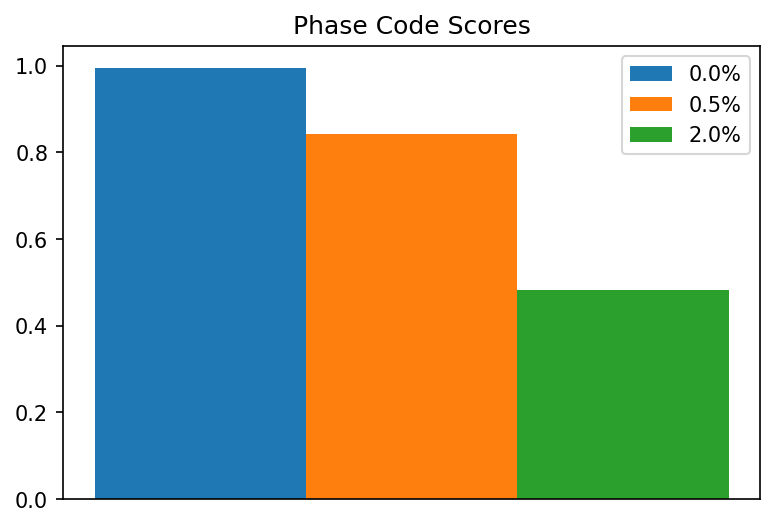

In [18]:
# Plot the results
fig, ax = plt.subplots(dpi=150)
width = 0.1

for i, (error_prob, score) in enumerate(phasecode_scores):
    
    x = width * i
    ax.bar(x, score, width=width, label=f'{error_prob * 100:.1f}%', align='edge')

ax.legend()
ax.set_title('Phase Code Scores')
ax.get_xaxis().set_visible(False)

## VQE

In [19]:
supermarq.vqe_proxy.VQEProxy?

Init signature: supermarq.vqe_proxy.VQEProxy(num_qubits: int, num_layers: int = 1) -> None
Docstring:     
Proxy benchmark of a full VQE application that targets a single iteration
of the whole variational optimization.

The benchmark is parameterized by the number of qubits, n. For each value of
n, we classically optimize the ansatz, sample 3 iterations near convergence,
and use the sampled parameters to execute the corresponding circuits on the
QPU. We take the measured energies from these experiments and average their
values and compute a score based on how closely the experimental results are
to the noiseless values.
File:           ~/Workspace/SuperTech/SupermarQ_HPCA_Artifact/supermarq/benchmarks/vqe_proxy.py
Type:           type
Subclasses:     


In [20]:
# Create the benchmark object and circuit
num_qubits = 3
num_layers = 2
vqe = supermarq.vqe_proxy.VQEProxy(num_qubits, num_layers)
vqe_circuit = vqe.circuit()
print('Z basis circuit:')
print(vqe_circuit[0])
print('\nX basis circuit:')
print(vqe_circuit[1])

Z basis circuit:
0: ───Ry(-0.394π)───Rz(1.13π)─────@───Ry(1.71π)───Rz(1.84π)────Ry(0.155π)───Rz(0.289π)────────────────@───Ry(1.7π)───Rz(-1.05π)────────────────M───
                                  │                                                                   │                                        │
1: ───Ry(-1.36π)────Rz(-0.682π)───X───@───────────Ry(0.903π)───Rz(-1.22π)───Ry(0.251π)───Rz(0.195π)───X───@──────────Ry(-0.893π)───Rz(1.64π)───M───
                                      │                                                                   │                                    │
2: ───Ry(-1.39π)────Rz(-1.03π)────────X───────────Ry(-1.17π)───Rz(-1.57π)───Ry(0.063π)───Rz(-1.39π)───────X──────────Ry(-0.83π)────Rz(1.9π)────M───

X basis circuit:
0: ───Ry(-0.394π)───Rz(1.13π)─────@───Ry(1.71π)───Rz(1.84π)────Ry(0.155π)───Rz(0.289π)────────────────@───Ry(1.7π)───Rz(-1.05π)────H───────────────M───
                                  │                                            

In [21]:
# Perform noisy simulation and evaluate the benchmark score function
vqe_scores = []
for error_prob in [0.0, 0.005, 0.02]:
    z_counts = noisy_simulation(vqe_circuit[0], p=error_prob)
    x_counts = noisy_simulation(vqe_circuit[1], p=error_prob)
    score = vqe.score([z_counts, x_counts])
    vqe_scores.append((error_prob, score))
    print(f'With {error_prob*100:.1f}% error probability, VQE score = {score:.4f}')

With 0.0% error probability, VQE score = 0.9943
With 0.5% error probability, VQE score = 0.9268
With 2.0% error probability, VQE score = 0.7897


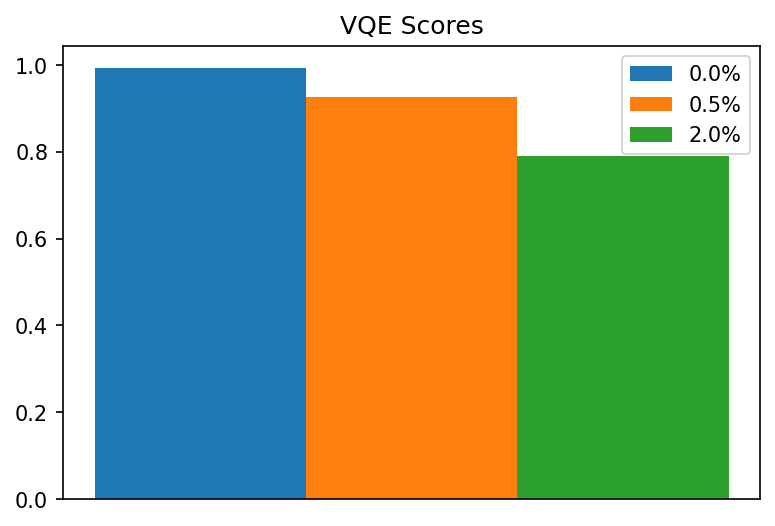

In [22]:
# Plot the results
fig, ax = plt.subplots(dpi=150)
width = 0.1

for i, (error_prob, score) in enumerate(vqe_scores):
    
    x = width * i
    ax.bar(x, score, width=width, label=f'{error_prob * 100:.1f}%', align='edge')

ax.legend()
ax.set_title('VQE Scores')
ax.get_xaxis().set_visible(False)

## Hamiltonian Simulation

In [23]:
supermarq.hamiltonian_simulation.HamiltonianSimulation?

Init signature:
supermarq.hamiltonian_simulation.HamiltonianSimulation(
    num_qubits: int,
    time_step: int,
    total_time: int,
) -> None
Docstring:     
Quantum benchmark focused on the ability to simulate 1D
Transverse Field Ising Models (TFIM) of variable length.

Device performance is based on how closely the experimentally obtained
average magnetization (along the Z-axis) matches the noiseless value.
Since the 1D TFIM is efficiently simulatable with classical algorithms,
computing the noiseless average magnetization remains scalable over a large
range of benchmark sizes.
Init docstring:
Args:
num_qubits: int
    Size of the TFIM chain, equivalent to the number of qubits.
time_step: int
    Size of the timestep in attoseconds.
total_time:
    Total simulation time of the TFIM chain in attoseconds.
File:           ~/Workspace/SuperTech/SupermarQ_HPCA_Artifact/supermarq/benchmarks/hamiltonian_simulation.py
Type:           type
Subclasses:     


In [24]:
# Create the benchmark object and circuit
num_qubits = 3
time_step = 1
total_time = 2
hamsim = supermarq.hamiltonian_simulation.HamiltonianSimulation(num_qubits, time_step, total_time)
hamsim_circuit = hamsim.circuit()
print(hamsim_circuit)

0: ───H───Rz(-0.75π)───H───@───────────────@───H───Rz(-0.749π)───H─────────────────────────@───────────────@───────────────────────M───
                           │               │                                               │               │                       │
1: ───H───Rz(-0.75π)───H───X───Rz(-0.5π)───X───@─────────────────@───H───Rz(-0.749π)───H───X───Rz(-0.5π)───X───@───────────────@───M───
                                               │                 │                                             │               │   │
2: ───H───Rz(-0.75π)───H───────────────────────X───Rz(-0.5π)─────X───H───Rz(-0.749π)───H───────────────────────X───Rz(-0.5π)───X───M───


In [25]:
# Perform noisy simulation and evaluate the benchmark score function
hamsim_scores = []
for error_prob in [0.0, 0.005, 0.02]:
    counts = noisy_simulation(hamsim_circuit, p=error_prob)
    score = hamsim.score(counts)
    hamsim_scores.append((error_prob, score))
    print(f'With {error_prob*100:.1f}% error probability, Hamiltonian Simulation score = {score:.4f}')

With 0.0% error probability, Hamiltonian Simulation score = 0.9992
With 0.5% error probability, Hamiltonian Simulation score = 0.9711
With 2.0% error probability, Hamiltonian Simulation score = 0.8624


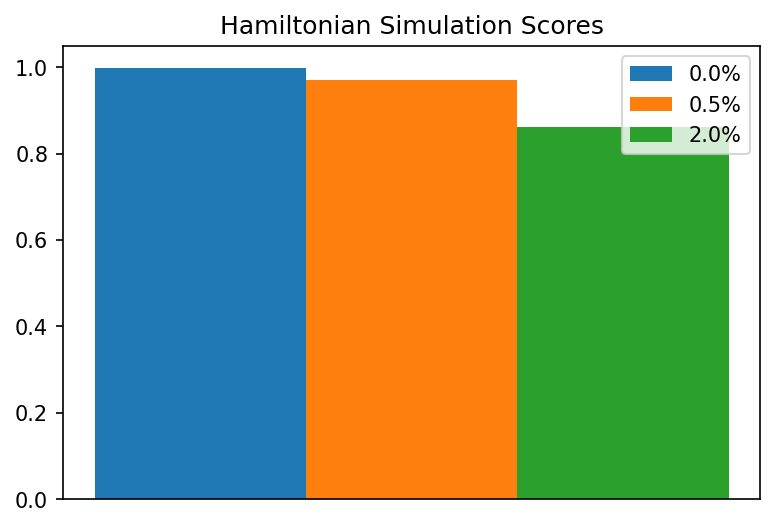

In [26]:
# Plot the results
fig, ax = plt.subplots(dpi=150)
width = 0.1

for i, (error_prob, score) in enumerate(hamsim_scores):
    
    x = width * i
    ax.bar(x, score, width=width, label=f'{error_prob * 100:.1f}%', align='edge')

ax.legend()
ax.set_title('Hamiltonian Simulation Scores')
ax.get_xaxis().set_visible(False)

## Fermionic-SWAP QAOA

In [27]:
supermarq.qaoa_fermionic_swap_proxy.QAOAFermionicSwapProxy?

Init signature: supermarq.qaoa_fermionic_swap_proxy.QAOAFermionicSwapProxy(num_qubits: int) -> None
Docstring:     
Proxy of a full Quantum Approximate Optimization Algorithm
(QAOA) benchmark. The benchmark targets MaxCut on a Sherrington-Kirkpatrick model.

Device performance is given by the Hellinger fidelity between the experimental
output distribution and the true distribution obtained via scalable, classical
simulation.
File:           ~/Workspace/SuperTech/SupermarQ_HPCA_Artifact/supermarq/benchmarks/qaoa_fermionic_swap_proxy.py
Type:           type
Subclasses:     


In [28]:
# Create the benchmark object and circuit
num_qubits = 3
fermionic_qaoa = supermarq.qaoa_fermionic_swap_proxy.QAOAFermionicSwapProxy(num_qubits)
fqaoa_circuit = fermionic_qaoa.circuit()
print(fqaoa_circuit)

0: ───H───@────────────────X───@────────────────────────────@────────────────────────X───@───Rx(1.48π)───M───
          │                │   │                            │                        │   │               │
1: ───H───X───Rz(-1.52π)───@───X───@────────────────X───@───X───────────Rz(-1.52π)───@───X───Rx(1.48π)───M───
                                   │                │   │                                                │
2: ───H────────────────────────────X───Rz(-1.52π)───@───X───Rx(1.48π)────────────────────────────────────M───


In [29]:
# Perform noisy simulation and evaluate the benchmark score function
fqaoa_scores = []
for error_prob in [0.0, 0.005, 0.02]:
    counts = noisy_simulation(fqaoa_circuit, p=error_prob)
    score = fermionic_qaoa.score(counts)
    fqaoa_scores.append((error_prob, score))
    print(f'With {error_prob*100:.1f}% error probability, Fermionic SWAP QAOA score = {score:.4f}')

With 0.0% error probability, Fermionic SWAP QAOA score = 1.0000
With 0.5% error probability, Fermionic SWAP QAOA score = 0.9073
With 2.0% error probability, Fermionic SWAP QAOA score = 0.6973


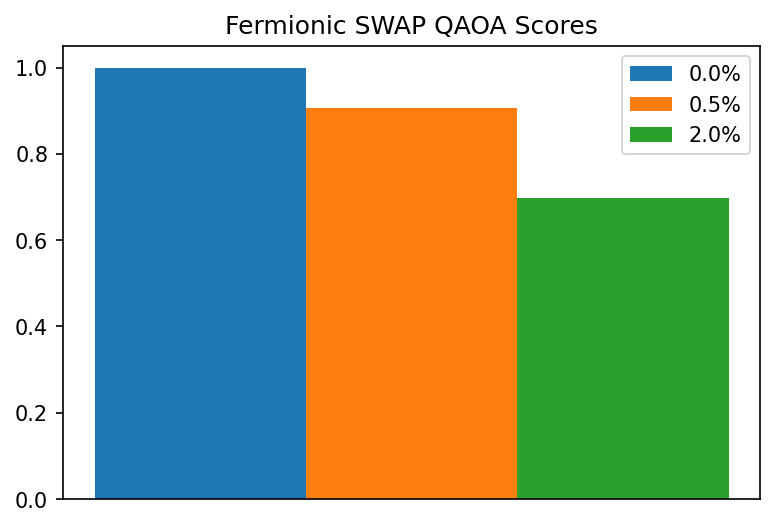

In [30]:
# Plot the results
fig, ax = plt.subplots(dpi=150)
width = 0.1

for i, (error_prob, score) in enumerate(fqaoa_scores):
    
    x = width * i
    ax.bar(x, score, width=width, label=f'{error_prob * 100:.1f}%', align='edge')

ax.legend()
ax.set_title('Fermionic SWAP QAOA Scores')
ax.get_xaxis().set_visible(False)

## Vanilla QAOA

In [31]:
supermarq.qaoa_vanilla_proxy.QAOAVanillaProxy?

Init signature: supermarq.qaoa_vanilla_proxy.QAOAVanillaProxy(num_qubits: int) -> None
Docstring:     
Proxy of a full Quantum Approximate Optimization Algorithm
(QAOA) benchmark. The benchmark targets MaxCut on a Sherrington-Kirkpatrick model.
Device performance is given by the Hellinger fidelity between the experimental
output distribution and the true distribution obtained via scalable, classical
simulation.
File:           ~/Workspace/SuperTech/SupermarQ_HPCA_Artifact/supermarq/benchmarks/qaoa_vanilla_proxy.py
Type:           type
Subclasses:     


In [32]:
# Create the benchmark object and circuit
num_qubits = 3
vanilla_qaoa = supermarq.qaoa_vanilla_proxy.QAOAVanillaProxy(num_qubits)
vqaoa_circuit = vanilla_qaoa.circuit()
print(vqaoa_circuit)

                                                      ┌───────────┐
0: ───H─────────────────────────@─────────────────@────@────────────────────────────@───Rx(0.637π)───M───
                                │                 │    │                            │                │
1: ───H───@─────────────────@───X───Rz(-0.637π)───X────┼Rx(0.637π)──────────────────┼────────────────M───
          │                 │                          │                            │                │
2: ───H───X───Rz(-0.637π)───X──────────────────────────X──────────────Rz(-0.637π)───X───Rx(0.637π)───M───
                                                      └───────────┘


In [33]:
# Perform noisy simulation and evaluate the benchmark score function
vqaoa_scores = []
for error_prob in [0.0, 0.005, 0.02]:
    counts = noisy_simulation(vqaoa_circuit, p=error_prob)
    score = vanilla_qaoa.score(counts)
    vqaoa_scores.append((error_prob, score))
    print(f'With {error_prob*100:.1f}% error probability, Vanilla QAOA score = {score:.4f}')

With 0.0% error probability, Vanilla QAOA score = 0.9749
With 0.5% error probability, Vanilla QAOA score = 0.9028
With 2.0% error probability, Vanilla QAOA score = 0.7299


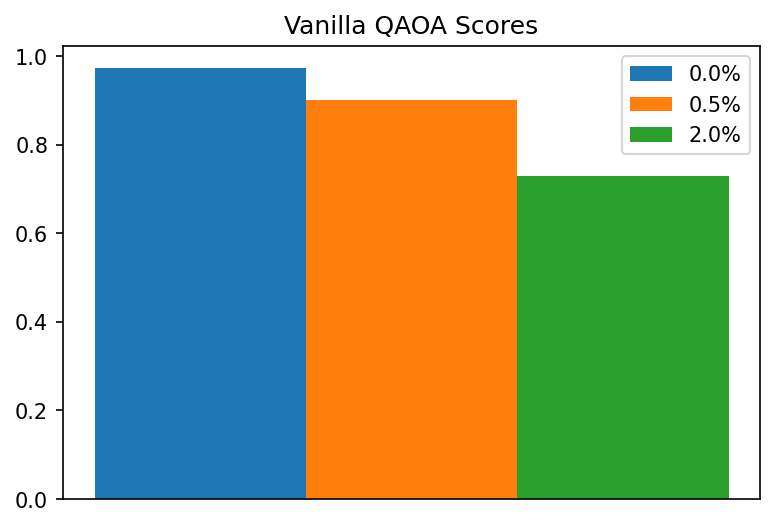

In [34]:
# Plot the results
fig, ax = plt.subplots(dpi=150)
width = 0.1

for i, (error_prob, score) in enumerate(vqaoa_scores):
    
    x = width * i
    ax.bar(x, score, width=width, label=f'{error_prob * 100:.1f}%', align='edge')

ax.legend()
ax.set_title('Vanilla QAOA Scores')
ax.get_xaxis().set_visible(False)

# Features

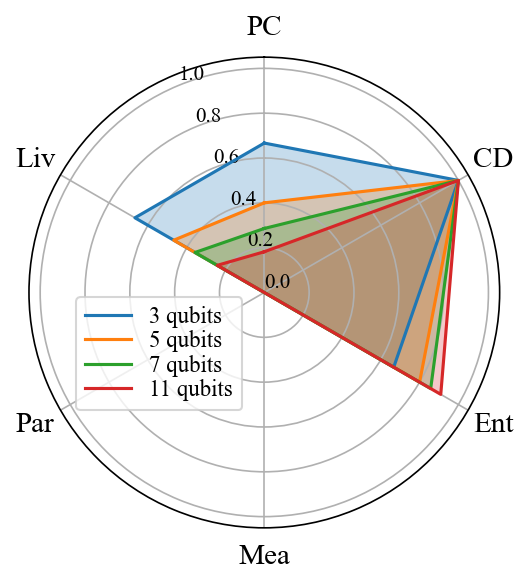

In [35]:
# GHZ feature example
title = 'GHZ'
labels = ['3 qubits', '5 qubits', '7 qubits', '11 qubits']
feature_vecs = []
for nq in [3, 5, 7, 11]:
    circ = supermarq.ghz.GHZ(nq).circuit()
    con = supermarq.features.compute_connectivity(circ)
    liv = supermarq.features.compute_liveness(circ)
    par = supermarq.features.compute_parallelism(circ)
    mea = supermarq.features.compute_measurement(circ)
    ent = supermarq.features.compute_entanglement(circ)
    dep = supermarq.features.compute_depth(circ)
    feature_vecs.append([con, liv, par, mea, ent, dep])
    
spoke_labels = ['PC', 'Liv', 'Par', 'Mea', 'Ent', 'CD']
supermarq.features.plot_benchmark([title, labels, feature_vecs], spoke_labels=spoke_labels, legend_loc=(0.1, 0.25))

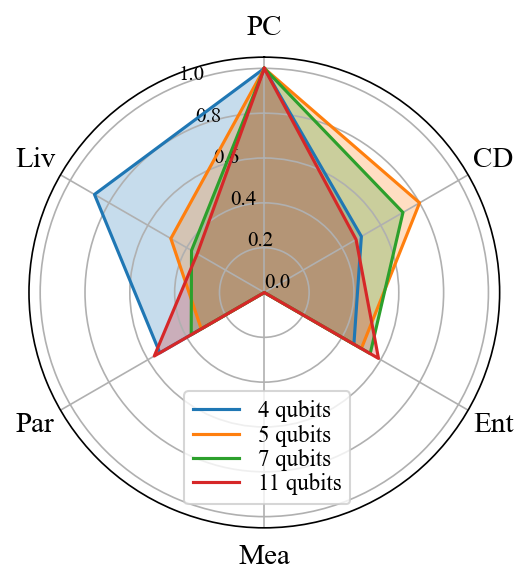

In [36]:
# Vanilla QAOA feature example
title = 'QAOA Vanilla Proxy'
labels = ['4 qubits', '5 qubits', '7 qubits', '11 qubits']
feature_vecs = []
for nq in [4, 5, 7, 11]:
    circ = supermarq.qaoa_vanilla_proxy.QAOAVanillaProxy(nq).circuit()
    con = supermarq.features.compute_connectivity(circ)
    liv = supermarq.features.compute_liveness(circ)
    par = supermarq.features.compute_parallelism(circ)
    mea = supermarq.features.compute_measurement(circ)
    ent = supermarq.features.compute_entanglement(circ)
    dep = supermarq.features.compute_depth(circ)
    feature_vecs.append([con, liv, par, mea, ent, dep])
    
spoke_labels = ['PC', 'Liv', 'Par', 'Mea', 'Ent', 'CD']
supermarq.features.plot_benchmark([title, labels, feature_vecs], spoke_labels=spoke_labels, legend_loc=(0.33, 0.05))

# Correlations

In [1]:
import pandas as pd
from plotting_functions import heatmap, annotate_heatmap, regression_plot

In [2]:
# Load the dataframes from the data/ directory
feature_df = pd.read_pickle('data/feature_dataframe.pickle')
score_df = pd.read_pickle('data/benchmark_scores_dataframe.pickle')

In [3]:
# Create the correlation dataframes including the error-correction benchmarks
correlation_wEC_df = pd.DataFrame(data=None, index=score_df.index, columns=feature_df.columns)
correlation_wEC_df.head()

,dagPar,ratPar,midMea,minLA,minLA_raw,MaxPC,CircuitArea,MaxLiveness,Communication,Liveness,Parallelism,Measurement,Entanglement,Depth,qubits,entangling-gates,regular-depth
aqt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
casablanca,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
guadalupe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ionq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lagos,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
for feature in correlation_wEC_df.columns:
    
    application_features = feature_df.loc[:, feature]
    
    for device in correlation_wEC_df.index:
        scores = score_df.loc[device, :]

        x, y = [], []
        for benchmark in scores.index:
            #if 'code' in benchmark:
            #    continue
            if isinstance(scores.loc[benchmark], tuple):
                x.append(application_features.loc[benchmark])
                y.append(scores.loc[benchmark][0])

        X = np.array(x)[:, np.newaxis]
        Y = np.array(y)
        model = LinearRegression().fit(X, Y)
        correlation = model.score(X, Y)        
        correlation_wEC_df.loc[device, feature] = correlation
correlation_wEC_df.head()

,dagPar,ratPar,midMea,minLA,minLA_raw,MaxPC,CircuitArea,MaxLiveness,Communication,Liveness,Parallelism,Measurement,Entanglement,Depth,qubits,entangling-gates,regular-depth
aqt,0.031627,0.048383,0.0,0.720323,0.826521,0.414922,0.171945,0.483527,0.668771,0.398907,0.142766,0.052058,0.218776,0.006584,0.012569,0.120897,0.062376
casablanca,0.032977,0.032281,0.407647,0.014266,0.067159,0.018833,0.014969,0.000512,0.000299,0.001076,0.003327,0.0036,0.05474,0.219284,0.094837,0.090542,0.037206
guadalupe,0.147291,0.138397,0.705502,0.001327,0.022122,0.081815,0.028088,0.000328,0.040862,0.005595,0.012663,0.072815,0.116696,0.25008,0.167247,0.030309,0.002409
ionq,0.34783,0.362205,0.021463,0.030662,0.157077,0.021392,0.063202,0.003143,0.000966,0.002885,0.149136,0.064872,0.017614,0.433451,0.299919,0.41144,0.327341
lagos,0.069881,0.068155,0.026881,0.181143,0.172761,0.000275,0.024599,0.054178,0.037172,0.051084,0.001184,0.009123,0.067479,0.14229,0.202392,0.183168,0.103301


In [7]:
# Create the correlation dataframes excluding the error-correction benchmarks
correlation_woEC_df = pd.DataFrame(data=None, index=score_df.index, columns=feature_df.columns)
correlation_woEC_df.head()

,dagPar,ratPar,midMea,minLA,minLA_raw,MaxPC,CircuitArea,MaxLiveness,Communication,Liveness,Parallelism,Measurement,Entanglement,Depth,qubits,entangling-gates,regular-depth
aqt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
casablanca,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
guadalupe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ionq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lagos,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
for feature in correlation_woEC_df.columns:
    
    application_features = feature_df.loc[:, feature]
    
    for device in correlation_woEC_df.index:
        scores = score_df.loc[device, :]

        x, y = [], []
        for benchmark in scores.index:
            if 'code' in benchmark:
                continue
            if isinstance(scores.loc[benchmark], tuple):
                x.append(application_features.loc[benchmark])
                y.append(scores.loc[benchmark][0])

        X = np.array(x)[:, np.newaxis]
        Y = np.array(y)
        model = LinearRegression().fit(X, Y)
        correlation = model.score(X, Y)        
        correlation_woEC_df.loc[device, feature] = correlation
correlation_woEC_df.head()

,dagPar,ratPar,midMea,minLA,minLA_raw,MaxPC,CircuitArea,MaxLiveness,Communication,Liveness,Parallelism,Measurement,Entanglement,Depth,qubits,entangling-gates,regular-depth
aqt,0.031627,0.048383,0.0,0.720323,0.826521,0.414922,0.171945,0.483527,0.668771,0.398907,0.142766,0.052058,0.218776,0.006584,0.012569,0.120897,0.062376
casablanca,0.180265,0.188487,0.0,0.191774,0.300473,0.00088,0.032931,0.086842,0.049059,0.098427,0.0,0.012767,0.179878,0.206811,0.249612,0.387237,0.226312
guadalupe,0.285829,0.276259,0.0,0.1802,0.289202,0.010107,0.004422,0.049858,0.056322,0.068861,0.001528,0.000535,0.403934,0.224499,0.235651,0.397397,0.263046
ionq,0.531978,0.505931,0.0,0.07744,0.267859,0.001132,0.107343,0.002329,0.008435,0.007892,0.078862,0.062507,0.174141,0.519661,0.293853,0.653188,0.509818
lagos,0.102619,0.10407,0.0,0.255093,0.219194,0.000786,0.020302,0.105932,0.064377,0.096375,0.000127,0.014154,0.128387,0.118837,0.227067,0.229572,0.130599


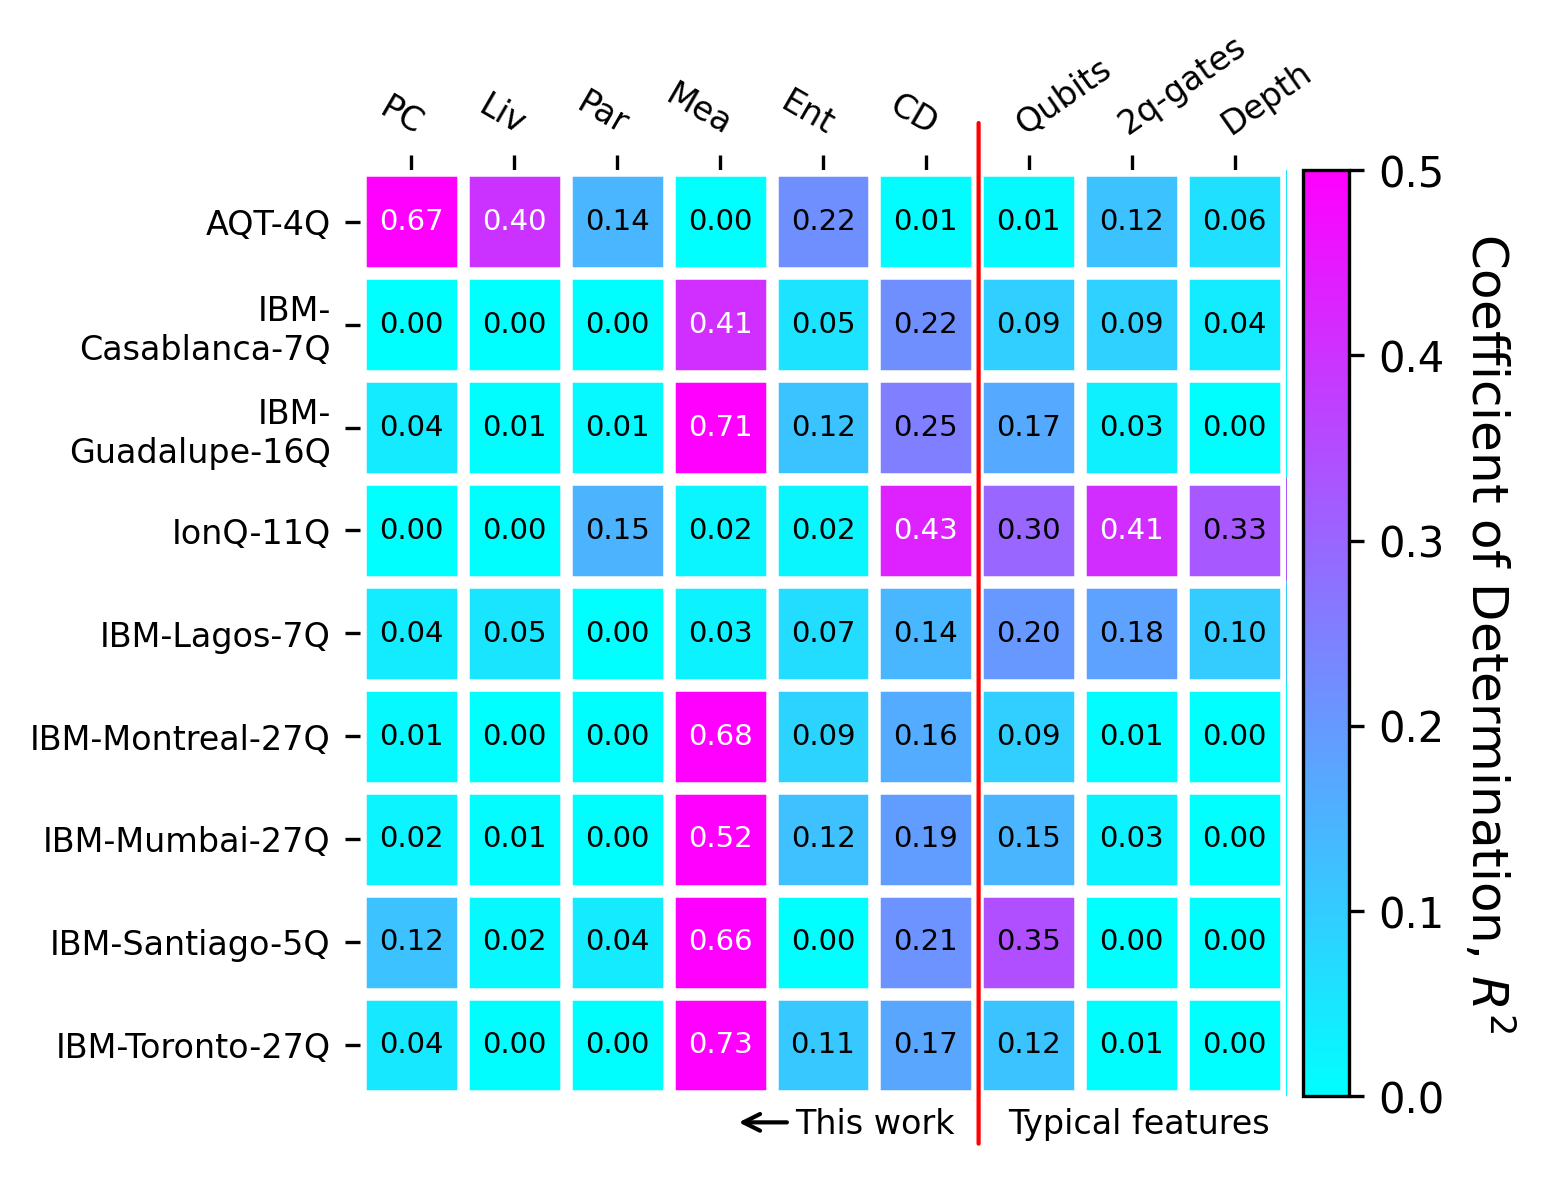

In [10]:
# Plot correlations INCLUDING error-correction Benchmarks
fig, ax = plt.subplots(dpi=300)

rows = ['AQT-4Q', 'IBM-\nCasablanca-7Q', 'IBM-\nGuadalupe-16Q', 'IonQ-11Q', 'IBM-Lagos-7Q', 'IBM-Montreal-27Q', 'IBM-Mumbai-27Q', 'IBM-Santiago-5Q', 'IBM-Toronto-27Q']
cols = ['PC', 'Liv', 'Par', 'Mea', 'Ent', 'CD', 'Qubits', '2q-gates', 'Depth']
subset_df = correlation_wEC_df.loc[:,[ 'Communication', 'Liveness', 'Parallelism', 'midMea', 'Entanglement', 'Depth', 'qubits', 'entangling-gates', 'regular-depth']]
im, _ = heatmap(subset_df.to_numpy(dtype=float), rows, cols, ax=ax,
                cmap="cool", vmin=0, vmax=0.5,
                cbarlabel=r"Coefficient of Determination, $R^2$",
                cbar_kw={'pad':0.01})

annotate_heatmap(im, size=7)

ax.annotate("", xy=(0.668, 1.06), xycoords='axes fraction',
            xytext=(0.668, -0.06), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="-", connectionstyle="arc3", color='r'))
ax.annotate("", xy=(0.4, -0.028), xycoords='axes fraction',
            xytext=(0.47, -0.028), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
ax.annotate('This work', (0.47,-0.04), xycoords='axes fraction', fontsize=8)
ax.annotate('Typical features', (0.7,-0.04), xycoords='axes fraction', fontsize=8, horizontalalignment='left')

plt.tight_layout()
plt.show()
plt.close()

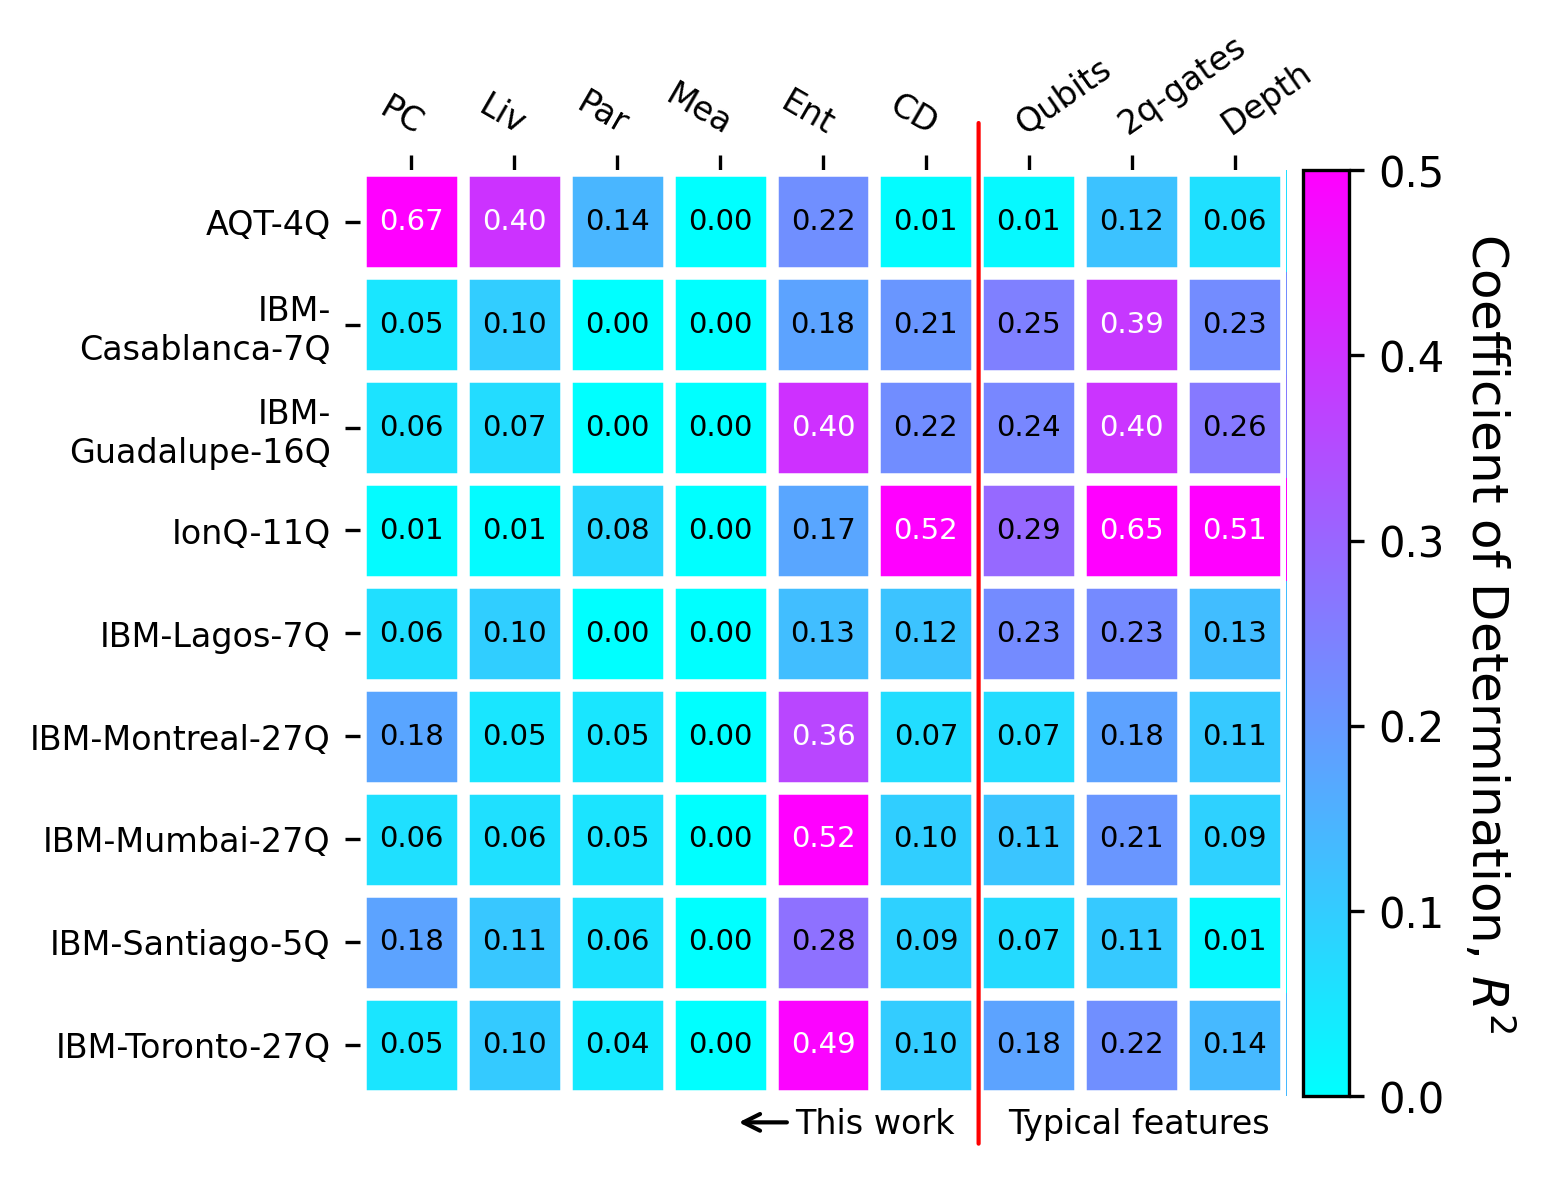

In [12]:
# Plot correlations EXCLUDING error-correction Benchmarks
fig, ax = plt.subplots(dpi=300)

rows = ['AQT-4Q', 'IBM-\nCasablanca-7Q', 'IBM-\nGuadalupe-16Q', 'IonQ-11Q', 'IBM-Lagos-7Q', 'IBM-Montreal-27Q', 'IBM-Mumbai-27Q', 'IBM-Santiago-5Q', 'IBM-Toronto-27Q']
cols = ['PC', 'Liv', 'Par', 'Mea', 'Ent', 'CD', 'Qubits', '2q-gates', 'Depth']
subset_df = correlation_woEC_df.loc[:,[ 'Communication', 'Liveness', 'Parallelism', 'midMea', 'Entanglement', 'Depth', 'qubits', 'entangling-gates', 'regular-depth']]
im, _ = heatmap(subset_df.to_numpy(dtype=float), rows, cols, ax=ax,
                cmap="cool", vmin=0, vmax=0.5,
                cbarlabel=r"Coefficient of Determination, $R^2$",
                cbar_kw={'pad':0.01})

annotate_heatmap(im, size=7)

ax.annotate("", xy=(0.668, 1.06), xycoords='axes fraction',
            xytext=(0.668, -0.06), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="-", connectionstyle="arc3", color='r'))
ax.annotate("", xy=(0.4, -0.028), xycoords='axes fraction',
            xytext=(0.47, -0.028), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
ax.annotate('This work', (0.47,-0.04), xycoords='axes fraction', fontsize=8)
ax.annotate('Typical features', (0.7,-0.04), xycoords='axes fraction', fontsize=8, horizontalalignment='left')

plt.tight_layout()
plt.show()
plt.close()

['dagPar', 'ratPar', 'midMea', 'minLA', 'minLA_raw', 'MaxPC', 'CircuitArea', 'MaxLiveness', 'Communication', 'Liveness', 'Parallelism', 'Measurement', 'Entanglement', 'Depth', 'qubits', 'entangling-gates', 'regular-depth']
['aqt', 'aspen9', 'casablanca', 'guadalupe', 'ionq', 'lagos', 'montreal', 'mumbai', 'santiago', 'toronto']
toronto Entanglement


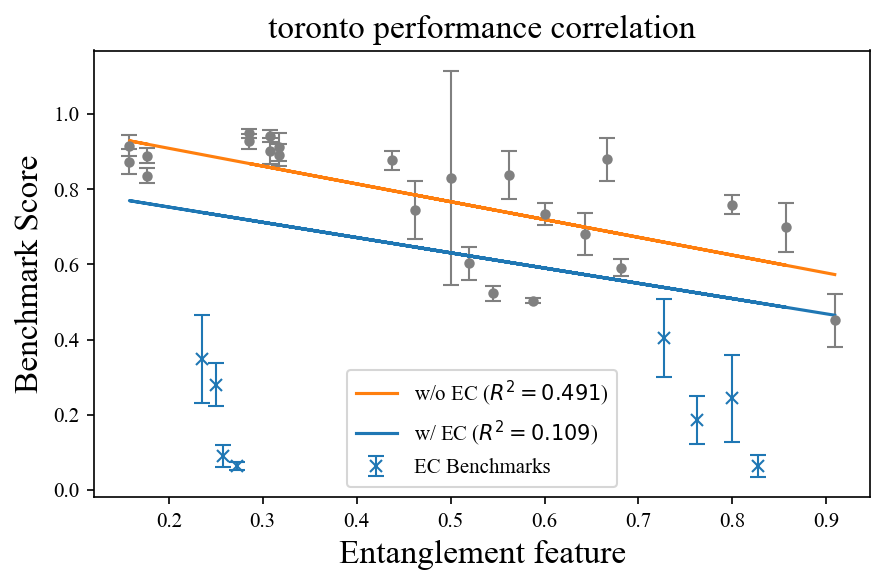

In [45]:
# Plot the perfomance correlation of between individual devices and features
print(list(feature_df.columns))
print(list(score_df.index))
device = 'toronto'
feature = 'Entanglement'
regression_plot(device, feature, feature_df, score_df)